In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error



import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# IMPORTAÇÃO DOS DADOS

In [ ]:
dados = pd.read_parquet('/content/drive/MyDrive/PROJETO APLICADO/parquet/df.parquet.gzip')

dados = dados.drop(columns='count')

In [ ]:
dados.tail()

,data,time_idx,cod_rep,coeficiente,valor,inpc_indice,selic_mes,cub/m2
22040,2022-08-01,151,25007,1.0,63.31,6625.14,1.17,1206.40
22186,2022-09-01,152,25007,1.0,58.14,6603.94,1.07,1208.43
22332,2022-10-01,153,25007,1.0,59.45,6634.98,1.02,1208.97
22478,2022-11-01,154,25007,1.0,56.02,6660.19,1.02,1209.77
22624,2022-12-01,155,25007,1.0,54.97,6706.15,1.12,1214.56


# FUNÇÕES

In [ ]:
# método para plot da decomposição
def plot_decomposition(decomposition):

    # plot handle
    fig, ax = plt.subplots(figsize=(6, 6), nrows=4)

    # original signal
    ax[0].plot(decomposition.observed)
    ax[0].set_title("Series")

    # trend component
    ax[1].plot(decomposition.trend)
    ax[1].set_title("Trend")

    # seasonal component
    ax[2].plot(decomposition.seasonal)
    ax[2].set_title("Seasonal")

    # residue
    ax[3].plot(decomposition.resid)
    ax[3].set_title("Residue")

    # plot configuration
    plt.show()


def test_stationarity(timeseries):
    print("Resultado do teste de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=["Teste Estatístico", "Valor-p", "#Lags Usados", "Número de Observações Usados"])
    for key, value in dftest[4].items():
        dfoutput[f"Valor crítico ({key})"] = value
    print(dfoutput)




def forecast_metrics(y_true, y_pred):
    """
    Função para calcular várias métricas de previsão em Python.

    Argumentos:
    y_true -- valores reais da série temporal
    y_pred -- previsões feitas pelo modelo

    Retorna:
    Um dicionário com as seguintes métricas de previsão:
    MAE, MSE, RMSE, MAPE
    """

    # Calcule as métricas de previsão
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Crie um dicionário com as métricas de previsão
    metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

    return metrics



# ANALISE E PREVISÃO: INPC

##  ANALISE

### **Transformação e visualização da série**

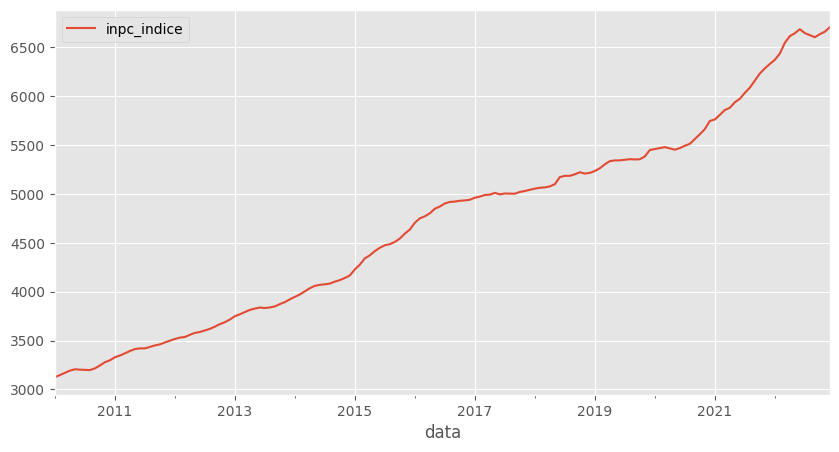

In [ ]:
df_inpc = dados[['data','inpc_indice']].copy()
df_inpc = df_inpc.drop_duplicates(subset='data')
df_inpc = df_inpc.sort_values(by='data')
df_inpc.index = df_inpc['data']
df_inpc = df_inpc.drop(columns='data')


df_inpc.plot(figsize=(10, 5));

### **Decomposição da série**

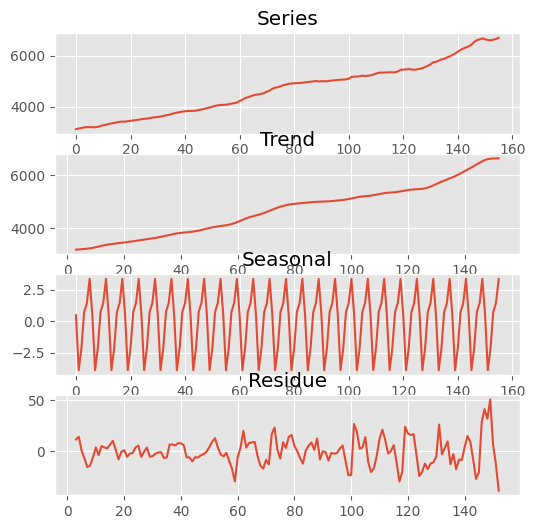

In [ ]:
decomposition = seasonal_decompose(df_inpc.values,
                                   model='additive',
                                   period=6)
plot_decomposition(decomposition)

### **Transformação logaritimica**

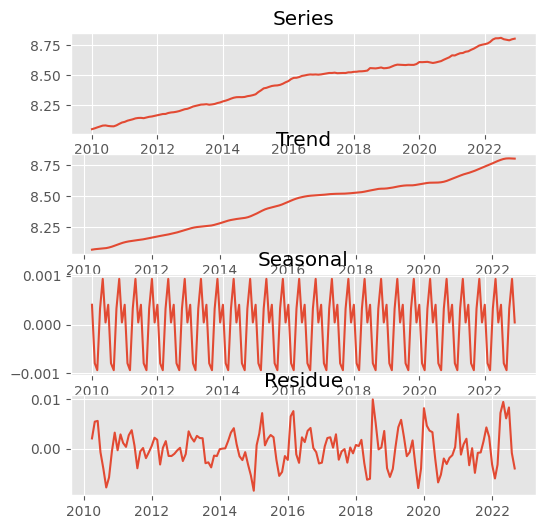

In [ ]:
# Aplicando a transformação logarítmica
inpc_log = np.log(df_inpc)

# Suavização exponencial tripla (Holt-Winters)
model = ExponentialSmoothing(inpc_log, trend='add', seasonal='add', seasonal_periods=6)
fit = model.fit()
data_log_smoothed = fit.fittedvalues

# Decomposição da série temporal transformada
result = seasonal_decompose(data_log_smoothed, model='additive', period=6)
plot_decomposition(result)


### **Analise do ACF E PACF**

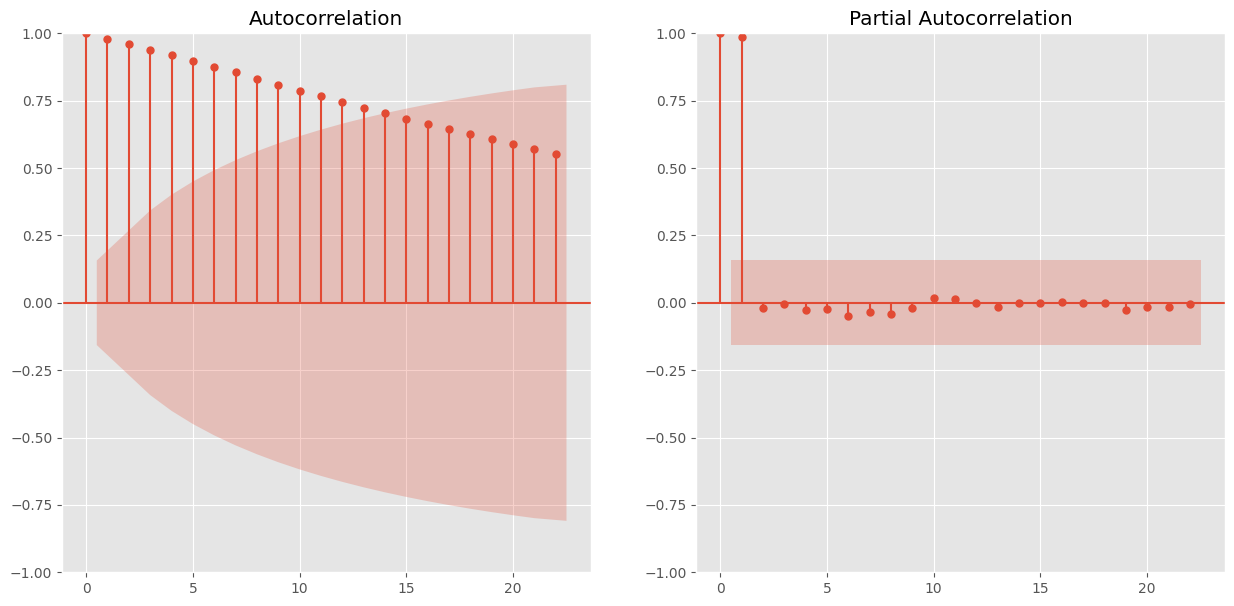

In [ ]:
# visualização da ACF e PACF
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
plot_acf(data_log_smoothed, ax=ax[0])
plot_pacf(data_log_smoothed, ax=ax[1])
plt.show()

## PREVISÃO USANDO SARIMAX

## **RESULTADO**

In [ ]:
# Modelagem e previsão com o modelo SARIMA
sarima_model = SARIMAX(data_log_smoothed, order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))
sarima_fit = sarima_model.fit()
forecast_log = sarima_fit.forecast(steps=10)
print("Previsão dos próximos 10 pontos da série temporal (log-transformada):\n", forecast_log)

# Revertendo a transformação logarítmica nas previsões
forecast = np.exp(forecast_log)
print("Previsão dos próximos 10 pontos da série temporal (valores originais):\n", forecast)

# Avaliação do modelo SARIMA
forecast_metrics(np.exp(data_log_smoothed.iloc[-10:]), forecast)

Previsão dos próximos 10 pontos da série temporal (log-transformada):
 2023-01-01    8.812330
2023-02-01    8.815895
2023-03-01    8.823886
2023-04-01    8.836221
2023-05-01    8.845213
2023-06-01    8.849091
2023-07-01    8.854147
2023-08-01    8.852740
2023-09-01    8.856696
2023-10-01    8.863315
Freq: MS, Name: predicted_mean, dtype: float64
Previsão dos próximos 10 pontos da série temporal (valores originais):
 2023-01-01    6716.547429
2023-02-01    6740.535232
2023-03-01    6794.616594
2023-04-01    6878.945473
2023-05-01    6941.085567
2023-06-01    6968.051074
2023-07-01    7003.372390
2023-08-01    6993.521754
2023-09-01    7021.243158
2023-10-01    7067.872289
Freq: MS, Name: predicted_mean, dtype: float64


{'MAE': 269.01445167525355,
 'MSE': 85315.56969585782,
 'RMSE': 292.088290925634,
 'MAPE': nan}

## PREVISÃO COM O MODELO AUTO ARIMA (DAODS TRANSFORMADOS)

### PRE PROCESSAMENTO

In [ ]:
# divisão em treino e teste
n, p = len(data_log_smoothed), 0.9
train = data_log_smoothed[:int(n*p)]
test = data_log_smoothed[int(n*p):]

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00


### MODELO

In [ ]:
import pmdarima as pm

# treinando o modelo
model = pm.auto_arima(train,
                      seasonal=True,
                      m=6,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

# relatório
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=-1088.017, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-1078.429, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=-1096.254, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=-1091.503, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=-987.904, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=-1097.725, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=-1095.762, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=-1093.314, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[6] intercept   : AIC=-1096.531, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=-1096.268, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=-1093.130, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[6] intercept   : AIC=-1094.485, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[6]             : AIC=-1071.010, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[6] intercept
Total fit time: 2.906 seconds
          

In [ ]:
# predição
forecast = model.predict(n_periods=len(test))

## **RESULTADO**

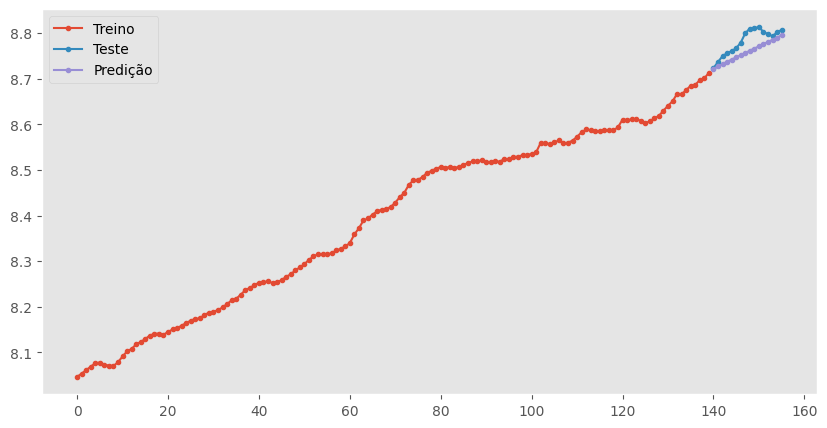

In [ ]:
# plot da predição
plt.figure(figsize=(10, 5))
plt.plot(np.arange(int(n*p)), train.values,'.-', label='Treino')
plt.plot(np.arange(int(n*p), n), test.values,'.-', label='Teste')
plt.plot(np.arange(int(n*p), n), forecast,'.-', label='Predição')
plt.grid()
plt.legend()
plt.show()

In [ ]:

forecast_metrics(test, forecast)


{'MAE': 0.022963877999559013,
 'MSE': 0.0007231920003580298,
 'RMSE': 0.026892229367570658,
 'MAPE': 0.26119197645810466}

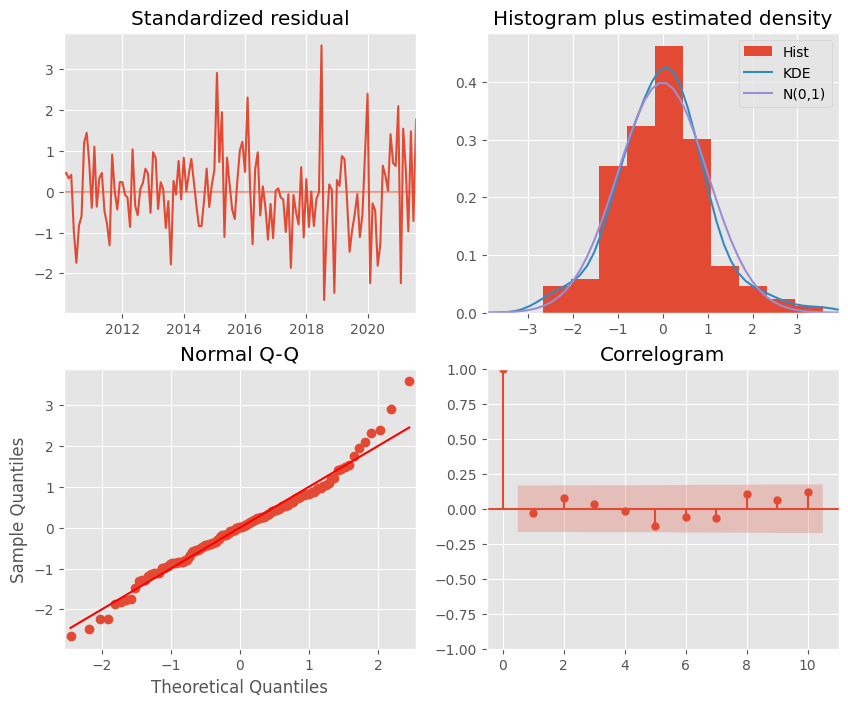

In [ ]:
# plot de diagnóstico
model.plot_diagnostics(figsize=(10, 8));

## PREVISÃO COM A REDE LSTM (DADOS TRANSFORMADOS)

In [ ]:
# utilizando o keras: https://keras.io/
import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# extraindo a série (np.array)
series = data_log_smoothed.values.reshape(-1, 1)

### PRE PROCESSAMENTO

In [ ]:
# extraindo a série (np.array)
series = df_inpc.values.reshape(-1, 1)

In [ ]:
# divisão em treino e teste
n, p = len(df_inpc), 0.9
train = series[:int(n*p)]
test = series[int(n*p):]

In [ ]:
# normalização (max 1 e min 0)
scaler_train = MinMaxScaler()
train = scaler_train.fit_transform(train)

In [ ]:
# normalização (max 1 e min 0)
scaler_test = MinMaxScaler()
test = scaler_test.fit_transform(test)

In [ ]:
# convertendo a série para uma estrutura x_train, y_train
x_train, y_train = train[:-1], train[1:]
x_test, y_test = test[:-1], test[1:]

In [ ]:
# x_train, y_train: primeiras 5 linhas
print(np.c_[x_train, y_train][:5, :])

[[0.         0.00738083]
 [0.00738083 0.01492029]
 [0.01492029 0.02272635]
 [0.02272635 0.02736004]
 [0.02736004 0.02616872]]


### MODELO

### TREINAMENTO

## **RESULTADO**

In [ ]:
# Definir o modelo
model = Sequential()
model.add(LSTM(64, input_shape=(1, 1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
model.fit(x_train, y_train, epochs=25, batch_size=1)


Epoch 1/35
139/139 [==============================] - 6s 40ms/step - loss: 0.0825
Epoch 2/35
139/139 [==============================] - 6s 44ms/step - loss: 0.0068
Epoch 3/35
139/139 [==============================] - 5s 39ms/step - loss: 6.0314e-04
Epoch 4/35
139/139 [==============================] - 6s 42ms/step - loss: 4.5623e-04
Epoch 5/35
139/139 [==============================] - 8s 55ms/step - loss: 4.3801e-04
Epoch 6/35
139/139 [==============================] - 11s 79ms/step - loss: 4.0963e-04
Epoch 7/35
139/139 [==============================] - 6s 40ms/step - loss: 3.3373e-04
Epoch 8/35
139/139 [==============================] - 6s 44ms/step - loss: 2.3736e-04
Epoch 9/35
139/139 [==============================] - 6s 40ms/step - loss: 2.3147e-04
Epoch 10/35
139/139 [==============================] - 6s 44ms/step - loss: 1.5479e-04
Epoch 11/35
139/139 [==============================] - 6s 40ms/step - loss: 1.3228e-04
Epoch 12/35
139/139 [==============================] - 6s 4

In [ ]:
# previsão
forecast = model.predict(x_test)

1/1 [==============================] - 0s 82ms/step


In [ ]:
# valores na escala original
forecast_orig = scaler_test.inverse_transform(forecast)
y_train_orig = scaler_train.inverse_transform(y_train)
y_test_orig = scaler_test.inverse_transform(y_test)

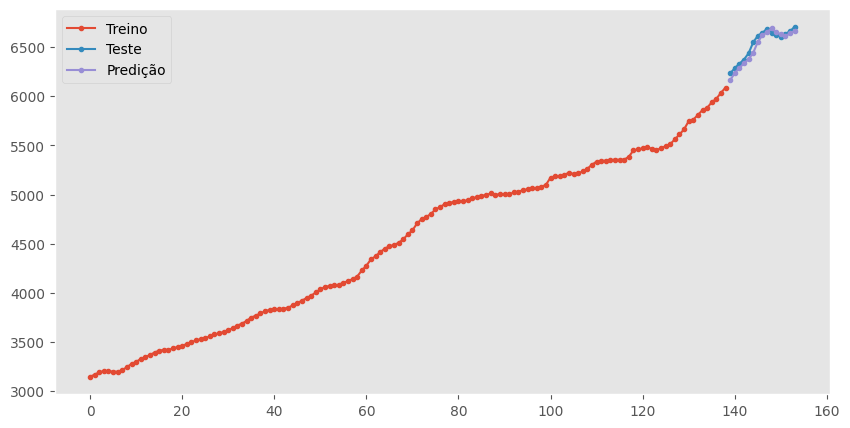

In [ ]:
# plot da predição
n_train, n_test = len(y_train), len(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_train), y_train_orig,'.-', label='Treino')
plt.plot(np.arange(n_train, n_train+n_test), y_test_orig,'.-', label='Teste')
plt.plot(np.arange(n_train, n_train+n_test), forecast_orig,'.-', label='Predição')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# RMSE
forecast_metrics(y_test_orig,forecast_orig)

{'MAE': 44.9655859374999,
 'MSE': 2494.9662043531257,
 'RMSE': 49.94963667889012,
 'MAPE': 0.6913699177872547}

#PREVISÃO INPC

In [ ]:
# Concatenar os dados de treinamento e teste
data = series

# Normalizar o array inteiro
scaler2 = MinMaxScaler()
data = scaler2.fit_transform(data)

# Definir o tamanho da janela de tempo e o número de previsões futuras
time_steps = 1
n_future_preds = 6

# Criar uma lista para armazenar as previsões futuras
future_preds = []

# Prever os próximos valores
for i in range(n_future_preds):
    # Selecionar a última janela de tempo
    last_window = data[-time_steps:]
    # Prever o próximo valor
    next_pred = model.predict(last_window.reshape(1, time_steps, 1))
    # Adicionar a previsão à lista de previsões futuras
    future_preds.append(next_pred[0][0])
    # Adicionar a previsão à janela de tempo e remover o primeiro valor
    data = np.concatenate((data, next_pred), axis=0)
    data = data[1:]

# Desnormalizar as previsões
future_preds = scaler2.inverse_transform(np.array(future_preds).reshape(-1, 1))

print(future_preds)

1/1 [==============================] - 0s 35ms/step
[[6739.656 ]
 [6773.185 ]
 [6806.7324]
 [6840.2905]
 [6873.854 ]
 [6907.417 ]]


In [ ]:
futuro_inpc = future_preds

# ANALISE E PREVISÃO: CUB

##  ANALISE

### **Transformação e visualização da série**

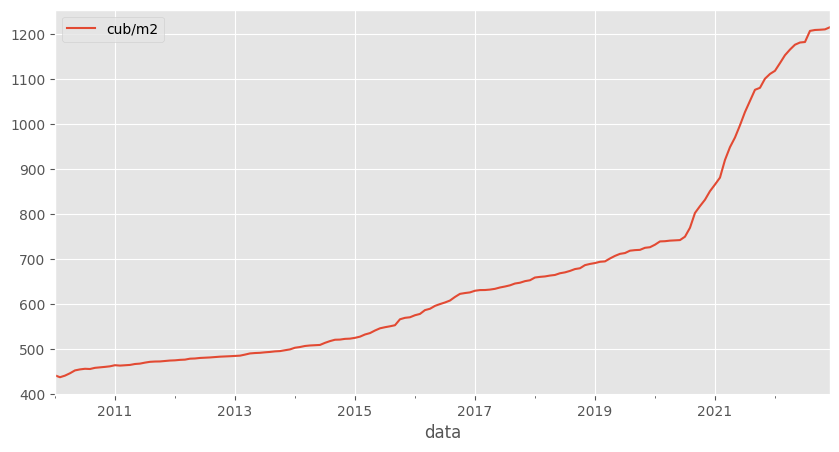

In [ ]:
df_cub = dados[['data','cub/m2']].copy()
df_cub = df_cub.drop_duplicates(subset='data')
df_cub = df_cub.sort_values(by='data')
df_cub.index = df_cub['data']
df_cub = df_cub.drop(columns='data')


df_cub.plot(figsize=(10, 5));

### **Decomposição da série**

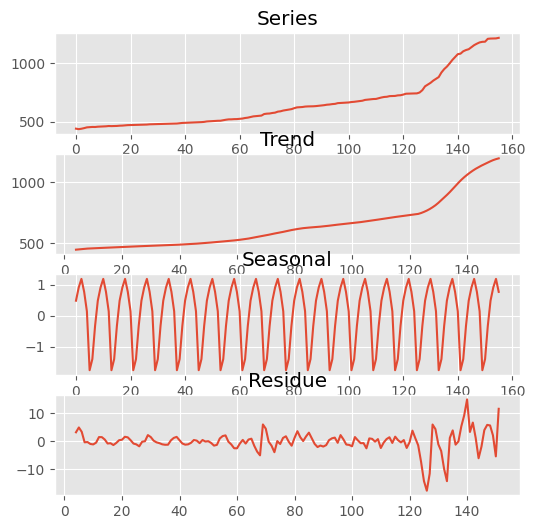

In [ ]:
decomposition = seasonal_decompose(df_cub.values,
                                   model='additive',
                                   period=8)
plot_decomposition(decomposition)

In [ ]:
# TENTATIVAS DE MELHORAR A SERIE

# diferenciando a série
df_diff = df_cub.diff(2).dropna()

# teste da série diferenciada
result = adfuller(df_diff.dropna())
print(f'p-value: {result[1]}')

p-value: 0.06072027083885831


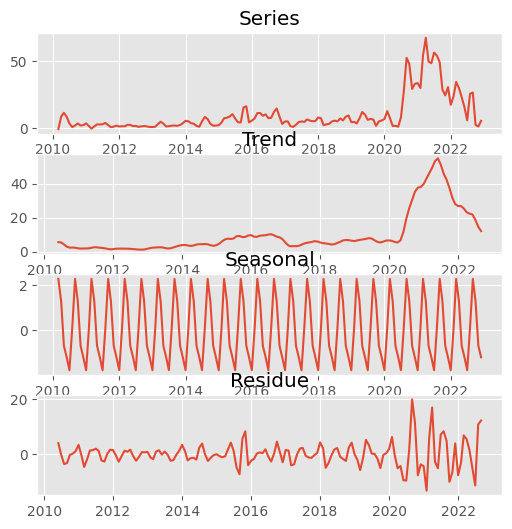

In [ ]:
# Decomposição da série temporal transformada
result = seasonal_decompose(df_diff, model='additive', period=6)
plot_decomposition(result)

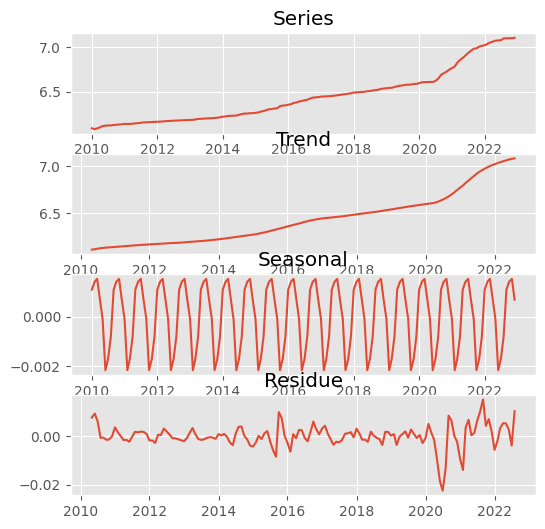

In [ ]:
# Decomposição da série temporal transformada
result = seasonal_decompose(np.log(df_cub), model='additive', period=8)
plot_decomposition(result)

### **Transformação logaritimica**

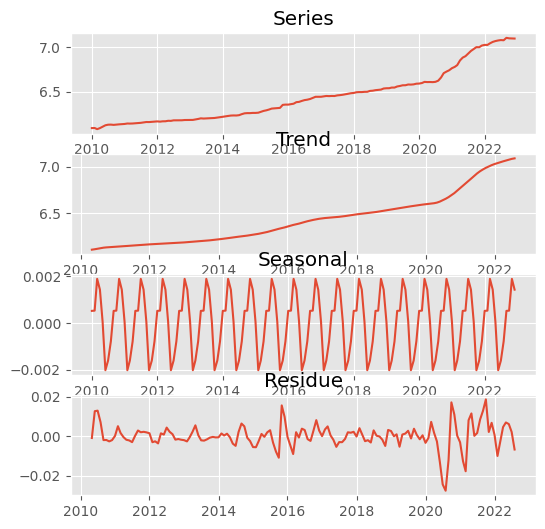

In [ ]:
# Aplicando a transformação logarítmica
cub_log = np.log(df_cub).copy()

# Suavização exponencial tripla (Holt-Winters)
model = ExponentialSmoothing(cub_log, trend='add', seasonal='add', seasonal_periods=8)
fit = model.fit()
data_log_smoothed = fit.fittedvalues

# Decomposição da série temporal transformada
result = seasonal_decompose(data_log_smoothed, model='additive', period=8)
plot_decomposition(result)


## PREVISÃO COM A REDE LSTM (DADOS TRANSFORMADOS)

In [ ]:
# utilizando o keras: https://keras.io/
import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# extraindo a série (np.array)
series = cub_log.values.reshape(-1, 1)

In [ ]:
# divisão em treino e teste
n, p = len(cub_log), 0.9
train = series[:int(n*p)]
test = series[int(n*p):]

In [ ]:
# normalização (max 1 e min 0)
scaler_train = MinMaxScaler()
train = scaler_train.fit_transform(train)

In [ ]:
# normalização (max 1 e min 0)
scaler_test = MinMaxScaler()
test = scaler_test.fit_transform(test)

In [ ]:
# convertendo a série para uma estrutura x_train, y_train
x_train, y_train = train[:-1], train[1:]
x_test, y_test = test[:-1], test[1:]

In [ ]:
# x_train, y_train: primeiras 5 linhas
print(np.c_[x_train, y_train][:5, :])

[[0.01079599 0.        ]
 [0.         0.00919344]
 [0.00919344 0.0226928 ]
 [0.0226928  0.03875958]
 [0.03875958 0.04436629]]


In [ ]:
# Definir o modelo
model = Sequential()
model.add(LSTM(64, input_shape=(1, 1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

In [ ]:
# Treinar o modelo
model.fit(x_train, y_train, epochs=20, batch_size=1)


Epoch 1/25
139/139 [==============================] - 6s 44ms/step - loss: 0.0538
Epoch 2/25
139/139 [==============================] - 9s 63ms/step - loss: 0.0068
Epoch 3/25
139/139 [==============================] - 6s 40ms/step - loss: 3.2765e-04
Epoch 4/25
139/139 [==============================] - 6s 45ms/step - loss: 2.7538e-04
Epoch 5/25
139/139 [==============================] - 6s 40ms/step - loss: 2.7522e-04
Epoch 6/25
139/139 [==============================] - 6s 44ms/step - loss: 2.0195e-04
Epoch 7/25
139/139 [==============================] - 6s 40ms/step - loss: 1.9770e-04
Epoch 8/25
139/139 [==============================] - 6s 43ms/step - loss: 1.6459e-04
Epoch 9/25
139/139 [==============================] - 6s 40ms/step - loss: 1.3116e-04
Epoch 10/25
139/139 [==============================] - 6s 41ms/step - loss: 1.7791e-04
Epoch 11/25
139/139 [==============================] - 6s 43ms/step - loss: 1.0077e-04
Epoch 12/25
139/139 [==============================] - 5s 39

In [ ]:
# previsão
forecast = model.predict(x_test)

1/1 [==============================] - 0s 48ms/step


In [ ]:
# valores na escala original
forecast_orig = np.exp(scaler_test.inverse_transform(forecast))
y_train_orig = np.exp(scaler_train.inverse_transform(y_train))
y_test_orig = np.exp(scaler_test.inverse_transform(y_test))

## **RESULTADO**

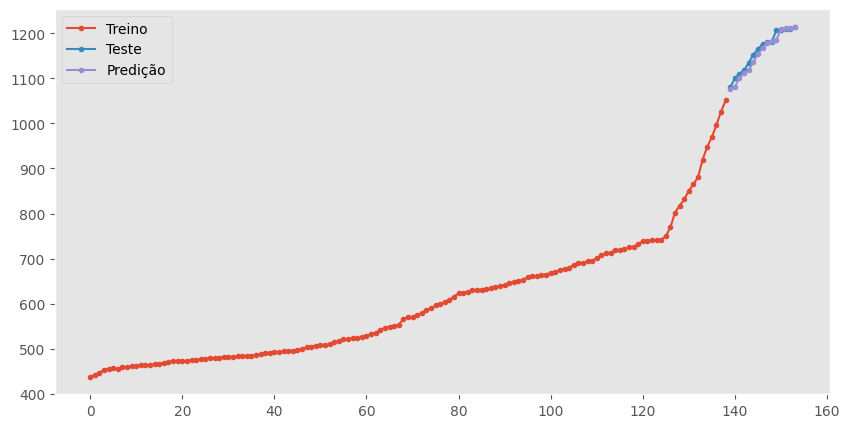

In [ ]:
# plot da predição
n_train, n_test = len(y_train), len(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_train), y_train_orig,'.-', label='Treino')
plt.plot(np.arange(n_train, n_train+n_test), y_test_orig,'.-', label='Teste')
plt.plot(np.arange(n_train, n_train+n_test), forecast_orig,'.-', label='Predição')
plt.grid()
plt.legend()
plt.show()

In [ ]:
forecast_metrics(y_test_orig, forecast_orig)

{'MAE': 8.320484374999918,
 'MSE': 115.69103275128678,
 'RMSE': 10.755976606114704,
 'MAPE': 0.7224273440195824}

In [ ]:
# Concatenar os dados de treinamento e teste
data = series

# Normalizar o array inteiro
scaler3 = MinMaxScaler()
data = scaler3.fit_transform(data)

# Definir o tamanho da janela de tempo e o número de previsões futuras
time_steps = 1
n_future_preds = 6

# Criar uma lista para armazenar as previsões futuras
future_preds = []

# Prever os próximos valores
for i in range(n_future_preds):
    # Selecionar a última janela de tempo
    last_window = data[-time_steps:]
    # Prever o próximo valor
    next_pred = model.predict(last_window.reshape(1, time_steps, 1))
    # Adicionar a previsão à lista de previsões futuras
    future_preds.append(next_pred[0][0])
    # Adicionar a previsão à janela de tempo e remover o primeiro valor
    data = np.concatenate((data, next_pred), axis=0)
    data = data[1:]

# Desnormalizar as previsões
future_preds2 = np.exp(scaler3.inverse_transform(np.array(future_preds).reshape(-1, 1)))

print(future_preds2)

1/1 [==============================] - 0s 48ms/step
[[1250.5641]
 [1289.1095]
 [1330.3734]
 [1374.5348]
 [1421.7694]
 [1472.2478]]


## PREVISÃO COM A REDE LSTM (DADOS ORIGINAIS)

### PRE PROCESSAMENTO

In [ ]:
# extraindo a série (np.array)
series = df_cub.values.reshape(-1, 1)

In [ ]:
# divisão em treino e teste
n, p = len(df_cub), 0.9
train = series[:int(n*p)]
test = series[int(n*p):]

In [ ]:
# normalização (max 1 e min 0)
scaler_train = MinMaxScaler()
train = scaler_train.fit_transform(train)

In [ ]:
# normalização (max 1 e min 0)
scaler_test = MinMaxScaler()
test = scaler_test.fit_transform(test)

In [ ]:
# convertendo a série para uma estrutura x_train, y_train
x_train, y_train = train[:-1], train[1:]
x_test, y_test = test[:-1], test[1:]

In [ ]:
# x_train, y_train: primeiras 5 linhas
print(np.c_[x_train, y_train][:5, :])

[[0.00677889 0.        ]
 [0.         0.00576857]
 [0.00576857 0.01432366]
 [0.01432366 0.02463865]
 [0.02463865 0.02827252]]


### MODELO

In [ ]:
# Definir o modelo
model = Sequential()
model.add(LSTM(30, input_shape=(1, 1), return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 30)             3840      
                                                                 
 lstm_15 (LSTM)              (None, 30)                7320      
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


### TREINAMENTO

In [ ]:
# fit no modelo
model.fit(x=x_train, y=y_train, batch_size=1, epochs=20)

Epoch 1/20
139/139 [==============================] - 5s 39ms/step - loss: 0.0620
Epoch 2/20
139/139 [==============================] - 6s 43ms/step - loss: 0.0241
Epoch 3/20
139/139 [==============================] - 5s 39ms/step - loss: 0.0061
Epoch 4/20
139/139 [==============================] - 6s 44ms/step - loss: 5.2367e-04
Epoch 5/20
139/139 [==============================] - 5s 38ms/step - loss: 3.6686e-04
Epoch 6/20
139/139 [==============================] - 10s 71ms/step - loss: 2.5927e-04
Epoch 7/20
139/139 [==============================] - 6s 44ms/step - loss: 2.6643e-04
Epoch 8/20
139/139 [==============================] - 6s 44ms/step - loss: 2.5766e-04
Epoch 9/20
139/139 [==============================] - 6s 41ms/step - loss: 2.1834e-04
Epoch 10/20
139/139 [==============================] - 6s 42ms/step - loss: 1.8704e-04
Epoch 11/20
139/139 [==============================] - 5s 38ms/step - loss: 1.6975e-04
Epoch 12/20
139/139 [==============================] - 6s 40ms/

In [ ]:
# previsão
forecast = model.predict(x_test)

1/1 [==============================] - 0s 30ms/step


In [ ]:
# valores na escala original
forecast_orig = scaler_test.inverse_transform(forecast)
y_train_orig = scaler_train.inverse_transform(y_train)
y_test_orig = scaler_test.inverse_transform(y_test)

## **RESULTADO**

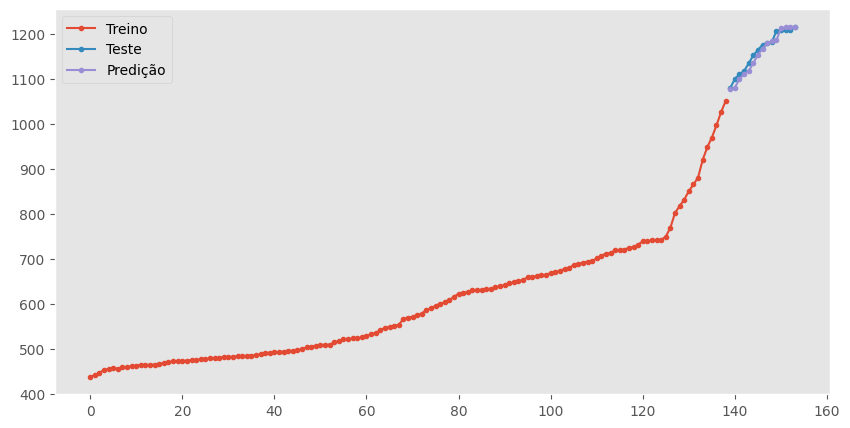

In [ ]:
# plot da predição
n_train, n_test = len(y_train), len(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_train), y_train_orig,'.-', label='Treino')
plt.plot(np.arange(n_train, n_train+n_test), y_test_orig,'.-', label='Teste')
plt.plot(np.arange(n_train, n_train+n_test), forecast_orig,'.-', label='Predição')
plt.grid()
plt.legend()
plt.show()

In [ ]:
forecast_metrics(y_test_orig, forecast_orig)

{'MAE': 9.033496744791652,
 'MSE': 122.79845830476758,
 'RMSE': 11.081446579971749,
 'MAPE': 0.7832359104202068}

In [ ]:
# Concatenar os dados de treinamento e teste
data = series

# Normalizar o array inteiro
scaler4 = MinMaxScaler()
data = scaler4.fit_transform(data)

# Definir o tamanho da janela de tempo e o número de previsões futuras
time_steps = 1
n_future_preds = 6

# Criar uma lista para armazenar as previsões futuras
future_preds = []

# Prever os próximos valores
for i in range(n_future_preds):
    # Selecionar a última janela de tempo
    last_window = data[-time_steps:]
    # Prever o próximo valor
    next_pred = model.predict(last_window.reshape(1, time_steps, 1))
    # Adicionar a previsão à lista de previsões futuras
    future_preds.append(next_pred[0][0])
    # Adicionar a previsão à janela de tempo e remover o primeiro valor
    data = np.concatenate((data, next_pred), axis=0)
    data = data[1:]

# Desnormalizar as previsões
future_preds2 = scaler4.inverse_transform(np.array(future_preds).reshape(-1, 1))

print(future_preds2)

1/1 [==============================] - 0s 28ms/step
[[1252.5248]
 [1293.4753]
 [1337.4156]
 [1384.245 ]
 [1433.7295]
 [1485.4777]]


# ANALISE E PREVISÃO: SELIC

##  ANALISE

### **Transformação e visualização da série**

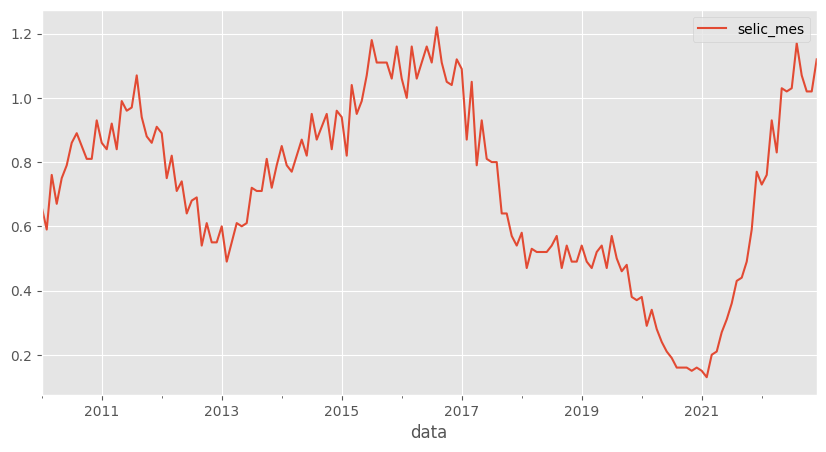

In [ ]:
df_selic = dados[['data','selic_mes']].copy()
df_selic = df_selic.drop_duplicates(subset='data')
df_selic = df_selic.sort_values(by='data')
df_selic.index = df_selic['data']
df_selic = df_selic.drop(columns='data')


df_selic.plot(figsize=(10, 5));

### **Decomposição da série**

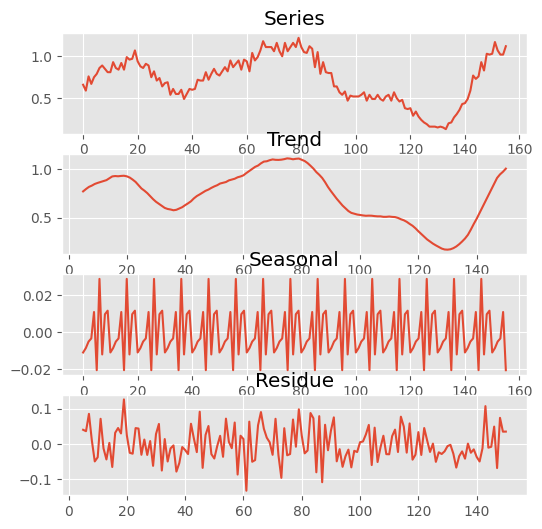

In [ ]:
decomposition = seasonal_decompose(df_selic.values,
                                   model='additive',
                                   period=10)
plot_decomposition(decomposition)

In [ ]:
# TENTATIVAS DE MELHORAR A SERIE

# diferenciando a série
df_diff = df_cub.diff(2).dropna()

# teste da série diferenciada
result = adfuller(df_diff.dropna())
print(f'p-value: {result[1]}')

p-value: 0.06072027083885831


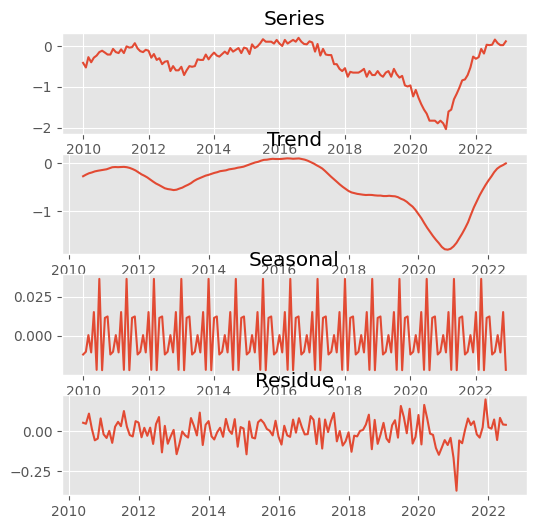

In [ ]:
# Decomposição da série temporal transformada
result = seasonal_decompose(np.log(df_selic), model='additive', period=10)
plot_decomposition(result)

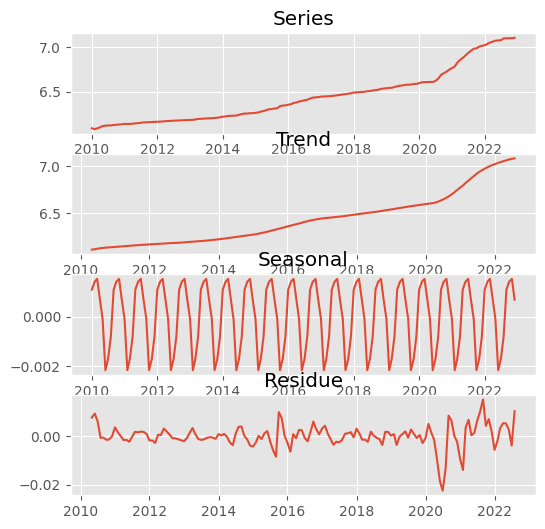

In [ ]:
# Decomposição da série temporal transformada
result = seasonal_decompose(np.log(df_cub), model='additive', period=8)
plot_decomposition(result)

### **Transformação logaritimica**

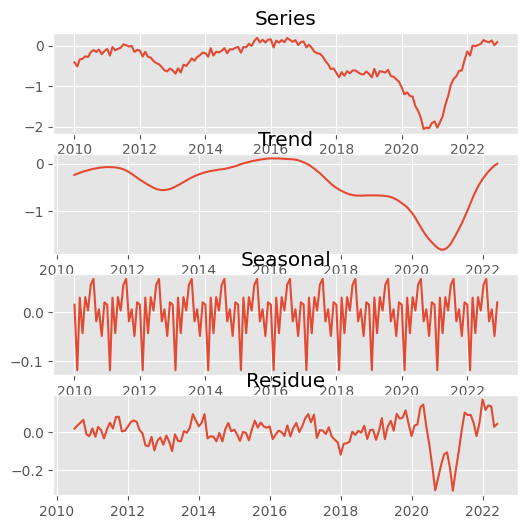

In [ ]:
# Aplicando a transformação logarítmica
selic_log = np.log(df_selic).copy()

# Suavização exponencial tripla (Holt-Winters)
model = ExponentialSmoothing(selic_log, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()
data_log_smoothed = fit.fittedvalues

# Decomposição da série temporal transformada
result = seasonal_decompose(data_log_smoothed, model='additive', period=12)
plot_decomposition(result)


## PREVISÃO COM A REDE LSTM (DADOS TRANSFORMADOS)

In [ ]:
# utilizando o keras: https://keras.io/
import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# extraindo a série (np.array)
series = selic_log.values.reshape(-1, 1)

In [ ]:
# divisão em treino e teste
n, p = len(selic_log), 0.9
train = series[:int(n*p)]
test = series[int(n*p):]

In [ ]:
# normalização (max 1 e min 0)
scaler_train = MinMaxScaler()
train = scaler_train.fit_transform(train)

In [ ]:
# normalização (max 1 e min 0)
scaler_test = MinMaxScaler()
test = scaler_test.fit_transform(test)

In [ ]:
# convertendo a série para uma estrutura x_train, y_train
x_train, y_train = train[:-1], train[1:]
x_test, y_test = test[:-1], test[1:]

In [ ]:
# x_train, y_train: primeiras 5 linhas
print(np.c_[x_train, y_train][:5, :])

[[0.72561562 0.6755425 ]
 [0.6755425  0.78862325]
 [0.78862325 0.73233174]
 [0.73233174 0.78270775]
 [0.78270775 0.80591368]]


In [ ]:
# construindo modelo
inputs = keras.layers.Input(shape=(1, 1))
lstm_out = keras.layers.LSTM(5)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 5)                 140       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit no modelo
model.fit(x=x_train, y=y_train, batch_size=1, epochs=50)

Epoch 1/50
139/139 [==============================] - 3s 5ms/step - loss: 0.3268
Epoch 2/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0872
Epoch 3/50
139/139 [==============================] - 1s 6ms/step - loss: 0.0235
Epoch 4/50
139/139 [==============================] - 1s 6ms/step - loss: 0.0186
Epoch 5/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0170
Epoch 6/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0152
Epoch 7/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 8/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0122
Epoch 9/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0106
Epoch 10/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0092
Epoch 11/50
139/139 [==============================] - 0s 3ms/step - loss: 0.0080
Epoch 12/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0070
Epoch 13/50
139/139 [====

In [ ]:
# previsão
forecast = model.predict(x_test)

1/1 [==============================] - 1s 1s/step


In [ ]:
# valores na escala original
forecast_orig = np.exp(scaler_test.inverse_transform(forecast))
y_train_orig = np.exp(scaler_train.inverse_transform(y_train))
y_test_orig = np.exp(scaler_test.inverse_transform(y_test))

## **RESULTADO**

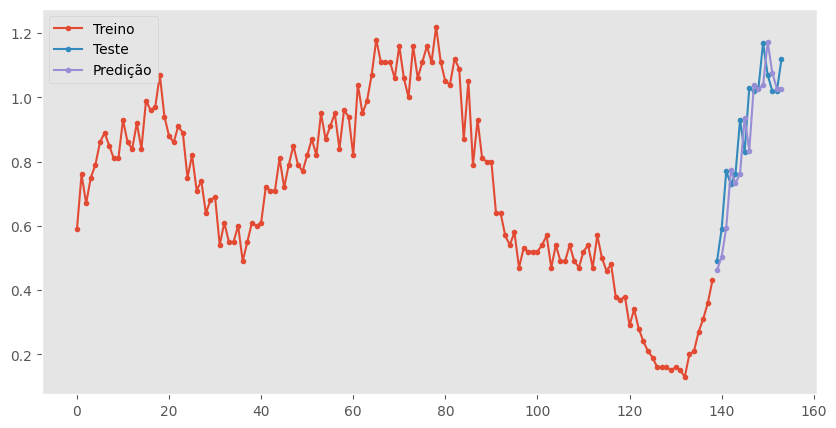

In [ ]:
# plot da predição
n_train, n_test = len(y_train), len(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_train), y_train_orig,'.-', label='Treino')
plt.plot(np.arange(n_train, n_train+n_test), y_test_orig,'.-', label='Teste')
plt.plot(np.arange(n_train, n_train+n_test), forecast_orig,'.-', label='Predição')
plt.grid()
plt.legend()
plt.show()

In [ ]:
forecast_metrics(y_test_orig, forecast_orig)

{'MAE': 0.08290613373120627,
 'MSE': 0.01066752367207501,
 'RMSE': 0.10328370477512418,
 'MAPE': 9.339857108944022}

In [ ]:
import numpy as np

# Defina o número de previsões futuras desejadas
n_future_preds = 12

# Pegue os últimos pontos de dados (de acordo com o número de timesteps)
input_data = X_test[-1]

# Crie uma lista para armazenar as previsões futuras
future_preds = []

for i in range(n_future_preds):
    # Faça a previsão para o próximo período
    pred = model.predict(input_data.reshape(1, -1, 1))

    # Atualize a entrada, removendo o valor mais antigo e adicionando a nova previsão
    input_data = np.append(input_data[1:], pred)

    # Armazene a previsão na lista
    future_preds.append(pred[0])

# Transforme as previsões futuras de volta à escala original
future_preds_orig_selic = np.exp(scaler_test.inverse_transform(future_preds))

## PREVISÃO COM A REDE LSTM (DADOS ORIGINAIS)

### PRE PROCESSAMENTO

In [ ]:
# extraindo a série (np.array)
series = df_selic.values.reshape(-1, 1)

In [ ]:
# divisão em treino e teste
n, p = len(df_selic), 0.9
train = series[:int(n*p)]
test = series[int(n*p):]

In [ ]:
# normalização (max 1 e min 0)
scaler_train = MinMaxScaler()
train = scaler_train.fit_transform(train)

In [ ]:
# normalização (max 1 e min 0)
scaler_test = MinMaxScaler()
test = scaler_test.fit_transform(test)

In [ ]:
# convertendo a série para uma estrutura x_train, y_train
x_train, y_train = train[:-1], train[1:]
x_test, y_test = test[:-1], test[1:]

In [ ]:
# x_train, y_train: primeiras 5 linhas
print(np.c_[x_train, y_train][:5, :])

[[0.48623853 0.42201835]
 [0.42201835 0.57798165]
 [0.57798165 0.49541284]
 [0.49541284 0.56880734]
 [0.56880734 0.60550459]]


### MODELO

In [ ]:
# construindo modelo
inputs = keras.layers.Input(shape=(1, 1))
lstm_out = keras.layers.LSTM(5)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 5)                 140       
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


### TREINAMENTO

In [ ]:
# fit no modelo
model.fit(x=x_train, y=y_train, batch_size=1, epochs=50)

Epoch 1/50
139/139 [==============================] - 2s 3ms/step - loss: 0.1281
Epoch 2/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0337
Epoch 3/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0219
Epoch 4/50
139/139 [==============================] - 1s 7ms/step - loss: 0.0181
Epoch 5/50
139/139 [==============================] - 1s 6ms/step - loss: 0.0146
Epoch 6/50
139/139 [==============================] - 1s 6ms/step - loss: 0.0118
Epoch 7/50
139/139 [==============================] - 1s 7ms/step - loss: 0.0097
Epoch 8/50
139/139 [==============================] - 1s 6ms/step - loss: 0.0080
Epoch 9/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0068
Epoch 10/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0062
Epoch 11/50
139/139 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 12/50
139/139 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 13/50
139/139 [====

In [ ]:
# previsão
forecast = model.predict(x_test)

1/1 [==============================] - 1s 635ms/step


In [ ]:
# valores na escala original
forecast_orig = scaler_test.inverse_transform(forecast)
y_train_orig = scaler_train.inverse_transform(y_train)
y_test_orig = scaler_test.inverse_transform(y_test)

## **RESULTADO**

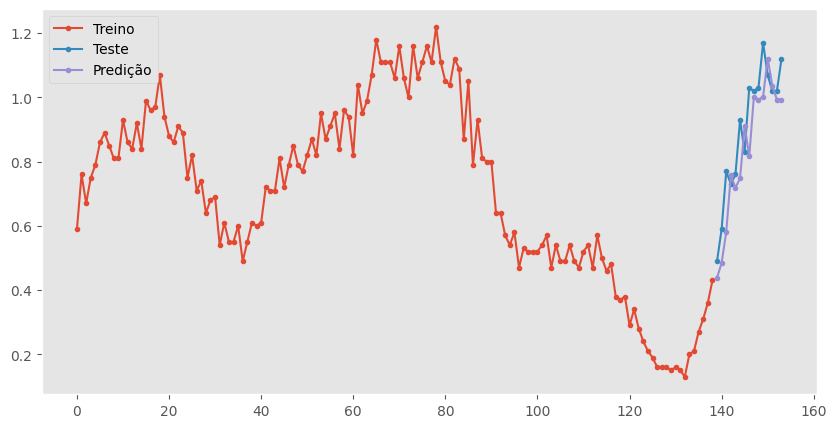

In [ ]:
# plot da predição
n_train, n_test = len(y_train), len(y_test)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n_train), y_train_orig,'.-', label='Treino')
plt.plot(np.arange(n_train, n_train+n_test), y_test_orig,'.-', label='Teste')
plt.plot(np.arange(n_train, n_train+n_test), forecast_orig,'.-', label='Predição')
plt.grid()
plt.legend()
plt.show()

In [ ]:
forecast_metrics(y_test_orig, forecast_orig)

{'MAE': 0.08911986343065897,
 'MSE': 0.012469275021567026,
 'RMSE': 0.11166590805419095,
 'MAPE': 10.161858257569625}